**Project:** Sentiment Analysis on Rotten Tomatoes Movie Reviews

1.Install & Import

In [10]:
!pip install -q nltk scikit-learn pandas matplotlib joblib

import os, re, string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# NLTK setup
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
# nltk.download('punkt_tab') # Removed this line
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
RANDOM_STATE = 42

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


2.Mount Drive & Load Dataset

In [11]:
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/data/rotten_tomatoes_reviews.csv')
print("Shape:", df.shape)
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (1444963, 11)
                                  id  reviewId creationDate       criticName  \
0                            beavers   1145982   2003-05-23  Ivan M. Lincoln   
1                         blood_mask   1636744   2007-06-02    The Foywonder   
2  city_hunter_shinjuku_private_eyes   2590987   2019-05-28     Reuben Baron   
3  city_hunter_shinjuku_private_eyes   2558908   2019-02-14      Matt Schley   
4                 dangerous_men_2015   2504681   2018-08-29        Pat Padua   

   isTopCritic originalScore reviewState                 publicatioName  \
0        False         3.5/4       fresh  Deseret News (Salt Lake City)   
1        False           1/5      rotten                  Dread Central   
2        False           NaN       fresh                            CBR   
3        False         2.5/5      rotten                    Japan Tim

3.Normalize Labels

In [12]:
# Rename columns if needed
if 'reviewText' in df.columns: df.rename(columns={'reviewText':'review'}, inplace=True)
if 'scoreSentiment' in df.columns: df.rename(columns={'scoreSentiment':'label'}, inplace=True)

print("Columns:", df.columns)
print("Unique labels:", df['label'].unique()[:10])

# Map labels to numeric
def map_label(x):
    if str(x).lower() in ['1','pos','positive','p','true','t','y','yes']:
        return 1
    if str(x).lower() in ['0','neg','negative','n','false','f','no']:
        return 0
    try:
        return int(x)
    except:
        return x

df['label_num'] = df['label'].apply(map_label)
df = df.dropna(subset=['review','label_num'])
df['label_num'] = df['label_num'].astype(int)

print(df['label_num'].value_counts())

Columns: Index(['id', 'reviewId', 'creationDate', 'criticName', 'isTopCritic',
       'originalScore', 'reviewState', 'publicatioName', 'review', 'label',
       'reviewUrl'],
      dtype='object')
Unique labels: ['POSITIVE' 'NEGATIVE']
label_num
1    922510
0    453228
Name: count, dtype: int64


4.Clean Text

In [13]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df['clean_review'] = df['review'].apply(clean_text)
df[['review','clean_review']].head(5)


,review,clean_review
0,Timed to be just long enough for most youngste...,timed long enough youngster brief attention sp...
1,It doesn't matter if a movie costs 300 million...,matter movie cost 300 million 300 dollar good ...
2,The choreography is so precise and lifelike at...,choreography precise lifelike point one might ...
3,The film's out-of-touch attempts at humor may ...,film touch attempt humor may find hunting reas...
4,Its clumsy determination is endearing and some...,clumsy determination endearing sometimes wildl...


5.Train/Test Split

In [14]:
X = df['clean_review']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (1100590,) Test: (275148,)


6.TF-IDF Vectorizer

In [15]:
vectorizer = TfidfVectorizer(
    max_features=8000,
    min_df=3,
    max_df=0.9,
    ngram_range=(1,2)
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Vectorized shapes:", X_train_vec.shape, X_test_vec.shape)


Vectorized shapes: (1100590, 8000) (275148, 8000)


7.Train Models

In [16]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'MultinomialNB': MultinomialNB(),
    'LinearSVC': LinearSVC(max_iter=5000, random_state=RANDOM_STATE)
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, digits=4))
    results[name] = {'model': model, 'accuracy': acc}

best_name = max(results, key=lambda k: results[k]['accuracy'])
print("\nBest model:", best_name, "Accuracy:", results[best_name]['accuracy'])
best_model = results[best_name]['model']



Training LogisticRegression ...
LogisticRegression Accuracy: 0.8104
              precision    recall  f1-score   support

           0     0.7577    0.6242    0.6845     90646
           1     0.8301    0.9019    0.8645    184502

    accuracy                         0.8104    275148
   macro avg     0.7939    0.7631    0.7745    275148
weighted avg     0.8062    0.8104    0.8052    275148


Training MultinomialNB ...
MultinomialNB Accuracy: 0.7812
              precision    recall  f1-score   support

           0     0.8025    0.4454    0.5729     90646
           1     0.7764    0.9461    0.8529    184502

    accuracy                         0.7812    275148
   macro avg     0.7895    0.6958    0.7129    275148
weighted avg     0.7850    0.7812    0.7607    275148


Training LinearSVC ...
LinearSVC Accuracy: 0.8104
              precision    recall  f1-score   support

           0     0.7576    0.6241    0.6844     90646
           1     0.8300    0.9019    0.8645    184502

   

8.Confusion Matrix

Confusion Matrix:
 [[ 56579  34067]
 [ 18094 166408]]


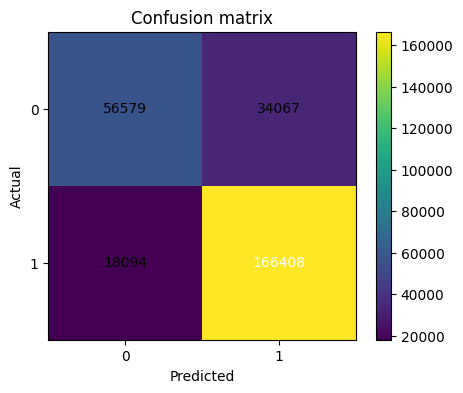

In [17]:
cm = confusion_matrix(y_test, best_model.predict(X_test_vec))
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0,1])
plt.yticks([0,1])
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, val, ha='center', va='center',
             color='white' if val>cm.max()/2 else 'black')
plt.show()

9.Save Model + Vectorizer

In [18]:
joblib.dump(best_model, '/content/drive/MyDrive/data/best_sentiment_model.joblib')
joblib.dump(vectorizer, '/content/drive/MyDrive/data/tfidf_vectorizer.joblib')
print("Saved model + vectorizer to Drive ✅")

Saved model + vectorizer to Drive ✅


10.Predict New Review

In [19]:
def predict_sentiment(text, model=best_model, vect=vectorizer):
    cleaned = clean_text(text)
    vec = vect.transform([cleaned])
    pred = model.predict(vec)[0]
    label = 'positive' if pred==1 else 'negative'
    return label

print(predict_sentiment("This movie was absolutely fantastic!"))
print(predict_sentiment("A boring and terrible experience."))

positive
negative
